<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:08:39] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


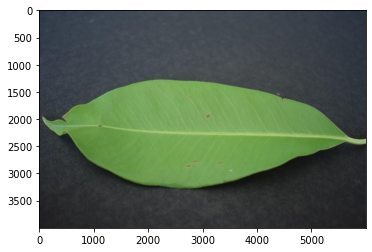

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

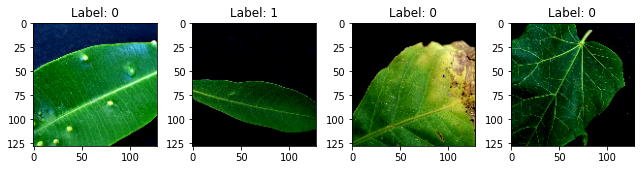

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:08:45] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:08:47] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2409978331452296 samples/sec                   batch loss = 1.1469151973724365 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2641944825557423 samples/sec                   batch loss = 0.4373903274536133 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2711293843341325 samples/sec                   batch loss = 2.077024459838867 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2477216562706075 samples/sec                   batch loss = 0.8051440715789795 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.262888397918312 samples/sec                   batch loss = 1.724186897277832 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2693859185398702 samples/sec                   batch loss = 0.5957077145576477 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.238935588068119 samples/sec                   batch loss = 1.6158883571624756 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2688045461898427 samples/sec                   batch loss = 0.7345699667930603 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2677612178270157 samples/sec                   batch loss = 0.7085736393928528 | accuracy = 0.5333333333333333


Epoch[1] Batch[50] Speed: 1.2717007438713068 samples/sec                   batch loss = 1.7420321702957153 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.2649731359718155 samples/sec                   batch loss = 0.5719398856163025 | accuracy = 0.5545454545454546


Epoch[1] Batch[60] Speed: 1.263975423878725 samples/sec                   batch loss = 0.7530158162117004 | accuracy = 0.5541666666666667


Epoch[1] Batch[65] Speed: 1.259238399123821 samples/sec                   batch loss = 0.4213950037956238 | accuracy = 0.5769230769230769


Epoch[1] Batch[70] Speed: 1.2616947793792228 samples/sec                   batch loss = 1.0084707736968994 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2643715946077585 samples/sec                   batch loss = 0.25849857926368713 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2555094618485918 samples/sec                   batch loss = 1.0509507656097412 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2663700393251256 samples/sec                   batch loss = 0.5308698415756226 | accuracy = 0.5882352941176471


Epoch[1] Batch[90] Speed: 1.2648052950911757 samples/sec                   batch loss = 0.4380950629711151 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.263268477802542 samples/sec                   batch loss = 0.3457946181297302 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.262765208703567 samples/sec                   batch loss = 0.4869716763496399 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.263673342725837 samples/sec                   batch loss = 1.2265292406082153 | accuracy = 0.6166666666666667


Epoch[1] Batch[110] Speed: 1.2583428549741966 samples/sec                   batch loss = 0.32028424739837646 | accuracy = 0.6181818181818182


Epoch[1] Batch[115] Speed: 1.262630545527341 samples/sec                   batch loss = 0.8425449132919312 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.262961220129643 samples/sec                   batch loss = 0.5710703730583191 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.265967934607867 samples/sec                   batch loss = 0.4029068648815155 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2611187227603329 samples/sec                   batch loss = 1.5034832954406738 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.2670336689641692 samples/sec                   batch loss = 0.6081944704055786 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2643762636440397 samples/sec                   batch loss = 0.893774151802063 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.2718513291118754 samples/sec                   batch loss = 0.6787625551223755 | accuracy = 0.6379310344827587


Epoch[1] Batch[150] Speed: 1.271673850516993 samples/sec                   batch loss = 0.9098862409591675 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.2701125182410247 samples/sec                   batch loss = 0.5109150409698486 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2696891038586564 samples/sec                   batch loss = 0.4761611223220825 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.271778345767952 samples/sec                   batch loss = 0.765047013759613 | accuracy = 0.6378787878787879


Epoch[1] Batch[170] Speed: 1.2675034786580608 samples/sec                   batch loss = 0.5395655035972595 | accuracy = 0.6367647058823529


Epoch[1] Batch[175] Speed: 1.2640926584490022 samples/sec                   batch loss = 0.5506439805030823 | accuracy = 0.64


Epoch[1] Batch[180] Speed: 1.2594797395432134 samples/sec                   batch loss = 0.5360874533653259 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.2738322077003863 samples/sec                   batch loss = 1.4132537841796875 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.26895665377935 samples/sec                   batch loss = 0.4631411135196686 | accuracy = 0.6407894736842106


Epoch[1] Batch[195] Speed: 1.2737018460049991 samples/sec                   batch loss = 0.6027405858039856 | accuracy = 0.6448717948717949


Epoch[1] Batch[200] Speed: 1.2802058924882023 samples/sec                   batch loss = 0.8345528244972229 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.2676222306207106 samples/sec                   batch loss = 0.8465077877044678 | accuracy = 0.6414634146341464


Epoch[1] Batch[210] Speed: 1.2719431245486714 samples/sec                   batch loss = 0.7409496903419495 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2672526404092863 samples/sec                   batch loss = 0.6230788230895996 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2668151557980607 samples/sec                   batch loss = 0.5556172728538513 | accuracy = 0.6465909090909091


Epoch[1] Batch[225] Speed: 1.266899050581749 samples/sec                   batch loss = 0.540388822555542 | accuracy = 0.6511111111111111


Epoch[1] Batch[230] Speed: 1.2627900157099683 samples/sec                   batch loss = 0.8626968264579773 | accuracy = 0.6532608695652173


Epoch[1] Batch[235] Speed: 1.2654121168759016 samples/sec                   batch loss = 0.4491828978061676 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.2640414192191343 samples/sec                   batch loss = 0.7612217664718628 | accuracy = 0.6552083333333333


Epoch[1] Batch[245] Speed: 1.2634742556785008 samples/sec                   batch loss = 0.4253924489021301 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2625992834500779 samples/sec                   batch loss = 0.7565214037895203 | accuracy = 0.659


Epoch[1] Batch[255] Speed: 1.2713848428658436 samples/sec                   batch loss = 0.6993975043296814 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2639050554873317 samples/sec                   batch loss = 0.44115766882896423 | accuracy = 0.6605769230769231


Epoch[1] Batch[265] Speed: 1.2701129990080422 samples/sec                   batch loss = 0.46286576986312866 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.2700358886310126 samples/sec                   batch loss = 0.3740784823894501 | accuracy = 0.662962962962963


Epoch[1] Batch[275] Speed: 1.266627795829506 samples/sec                   batch loss = 0.45246586203575134 | accuracy = 0.6645454545454546


Epoch[1] Batch[280] Speed: 1.2779278716235645 samples/sec                   batch loss = 0.5161589980125427 | accuracy = 0.6669642857142857


Epoch[1] Batch[285] Speed: 1.2740217052474028 samples/sec                   batch loss = 1.0067440271377563 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.277828202905569 samples/sec                   batch loss = 2.2557437419891357 | accuracy = 0.6637931034482759


Epoch[1] Batch[295] Speed: 1.274108492468906 samples/sec                   batch loss = 0.3053548038005829 | accuracy = 0.6661016949152543


Epoch[1] Batch[300] Speed: 1.2761758150111242 samples/sec                   batch loss = 0.7261843085289001 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.2679242864645213 samples/sec                   batch loss = 0.8518267869949341 | accuracy = 0.6647540983606557


Epoch[1] Batch[310] Speed: 1.264509965170461 samples/sec                   batch loss = 0.09598065167665482 | accuracy = 0.6669354838709678


Epoch[1] Batch[315] Speed: 1.2703245718133016 samples/sec                   batch loss = 0.6478402018547058 | accuracy = 0.665079365079365


Epoch[1] Batch[320] Speed: 1.262476150629819 samples/sec                   batch loss = 0.6820473670959473 | accuracy = 0.66484375


Epoch[1] Batch[325] Speed: 1.2626158170002029 samples/sec                   batch loss = 0.538666844367981 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.263137321067575 samples/sec                   batch loss = 0.636476457118988 | accuracy = 0.6651515151515152


Epoch[1] Batch[335] Speed: 1.264577160147662 samples/sec                   batch loss = 0.6827356815338135 | accuracy = 0.6664179104477612


Epoch[1] Batch[340] Speed: 1.2636763885215945 samples/sec                   batch loss = 0.8166747689247131 | accuracy = 0.6669117647058823


Epoch[1] Batch[345] Speed: 1.2622952003755914 samples/sec                   batch loss = 0.5620351433753967 | accuracy = 0.6666666666666666


Epoch[1] Batch[350] Speed: 1.2703258222257288 samples/sec                   batch loss = 0.7274978756904602 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.278199021946921 samples/sec                   batch loss = 0.22747881710529327 | accuracy = 0.6676056338028169


Epoch[1] Batch[360] Speed: 1.271300738280004 samples/sec                   batch loss = 0.47299888730049133 | accuracy = 0.6701388888888888


Epoch[1] Batch[365] Speed: 1.2810082153892484 samples/sec                   batch loss = 0.43458113074302673 | accuracy = 0.6719178082191781


Epoch[1] Batch[370] Speed: 1.27036218144812 samples/sec                   batch loss = 0.7673594951629639 | accuracy = 0.6709459459459459


Epoch[1] Batch[375] Speed: 1.2752175450405872 samples/sec                   batch loss = 0.6698001027107239 | accuracy = 0.67


Epoch[1] Batch[380] Speed: 1.2733295724158638 samples/sec                   batch loss = 0.5690600872039795 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.2770789469277273 samples/sec                   batch loss = 0.5417401790618896 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2705318853429597 samples/sec                   batch loss = 0.3347259759902954 | accuracy = 0.6737179487179488


Epoch[1] Batch[395] Speed: 1.2626740679572865 samples/sec                   batch loss = 0.898907482624054 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2676488570982134 samples/sec                   batch loss = 0.5970908999443054 | accuracy = 0.675625


Epoch[1] Batch[405] Speed: 1.2553281548065984 samples/sec                   batch loss = 0.3150038421154022 | accuracy = 0.678395061728395


Epoch[1] Batch[410] Speed: 1.2595285293390095 samples/sec                   batch loss = 0.3787209987640381 | accuracy = 0.6798780487804879


Epoch[1] Batch[415] Speed: 1.2619951557822209 samples/sec                   batch loss = 0.5590662956237793 | accuracy = 0.6819277108433734


Epoch[1] Batch[420] Speed: 1.26141778164904 samples/sec                   batch loss = 0.6303815841674805 | accuracy = 0.6815476190476191


Epoch[1] Batch[425] Speed: 1.264443539708985 samples/sec                   batch loss = 0.38125914335250854 | accuracy = 0.6829411764705883


Epoch[1] Batch[430] Speed: 1.2644661254888654 samples/sec                   batch loss = 0.6024364233016968 | accuracy = 0.6808139534883721


Epoch[1] Batch[435] Speed: 1.2716839715383554 samples/sec                   batch loss = 0.31527990102767944 | accuracy = 0.6816091954022988


Epoch[1] Batch[440] Speed: 1.2739224514152947 samples/sec                   batch loss = 0.38900548219680786 | accuracy = 0.68125


Epoch[1] Batch[445] Speed: 1.27823076914872 samples/sec                   batch loss = 0.8407756686210632 | accuracy = 0.6814606741573034


Epoch[1] Batch[450] Speed: 1.2614454759487468 samples/sec                   batch loss = 0.9577542543411255 | accuracy = 0.68


Epoch[1] Batch[455] Speed: 1.2706296492086404 samples/sec                   batch loss = 0.3708541691303253 | accuracy = 0.6802197802197802


Epoch[1] Batch[460] Speed: 1.266999413670096 samples/sec                   batch loss = 0.9530856609344482 | accuracy = 0.6798913043478261


Epoch[1] Batch[465] Speed: 1.268816156903127 samples/sec                   batch loss = 0.37492480874061584 | accuracy = 0.6801075268817204


Epoch[1] Batch[470] Speed: 1.2674476537713315 samples/sec                   batch loss = 1.0698734521865845 | accuracy = 0.6797872340425531


Epoch[1] Batch[475] Speed: 1.2667685736408765 samples/sec                   batch loss = 0.3871619701385498 | accuracy = 0.6810526315789474


Epoch[1] Batch[480] Speed: 1.2689202789939862 samples/sec                   batch loss = 2.525787591934204 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.2655046079026604 samples/sec                   batch loss = 0.8227025866508484 | accuracy = 0.6824742268041237


Epoch[1] Batch[490] Speed: 1.2744990361046182 samples/sec                   batch loss = 0.4647064805030823 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.2652587585631243 samples/sec                   batch loss = 0.2784309983253479 | accuracy = 0.6843434343434344


Epoch[1] Batch[500] Speed: 1.2621806728524283 samples/sec                   batch loss = 0.17704534530639648 | accuracy = 0.6865


Epoch[1] Batch[505] Speed: 1.2641839088497235 samples/sec                   batch loss = 0.41099947690963745 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.26813925239932 samples/sec                   batch loss = 0.27880486845970154 | accuracy = 0.6872549019607843


Epoch[1] Batch[515] Speed: 1.2694510392952727 samples/sec                   batch loss = 0.14676642417907715 | accuracy = 0.6888349514563107


Epoch[1] Batch[520] Speed: 1.2737247637467235 samples/sec                   batch loss = 0.28350940346717834 | accuracy = 0.6899038461538461


Epoch[1] Batch[525] Speed: 1.2725917590030327 samples/sec                   batch loss = 0.7637227773666382 | accuracy = 0.6895238095238095


Epoch[1] Batch[530] Speed: 1.2742574225089887 samples/sec                   batch loss = 0.9132353663444519 | accuracy = 0.6891509433962264


Epoch[1] Batch[535] Speed: 1.260391390173446 samples/sec                   batch loss = 0.7579511404037476 | accuracy = 0.6901869158878504


Epoch[1] Batch[540] Speed: 1.2648136860773904 samples/sec                   batch loss = 0.44740691781044006 | accuracy = 0.6902777777777778


Epoch[1] Batch[545] Speed: 1.269595615884051 samples/sec                   batch loss = 0.32236072421073914 | accuracy = 0.6903669724770642


Epoch[1] Batch[550] Speed: 1.271634717416798 samples/sec                   batch loss = 0.5408179759979248 | accuracy = 0.6918181818181818


Epoch[1] Batch[555] Speed: 1.2685100313981867 samples/sec                   batch loss = 0.5330824851989746 | accuracy = 0.6905405405405406


Epoch[1] Batch[560] Speed: 1.2752083369595646 samples/sec                   batch loss = 0.4882778823375702 | accuracy = 0.6910714285714286


Epoch[1] Batch[565] Speed: 1.276534408539317 samples/sec                   batch loss = 0.5451984405517578 | accuracy = 0.6902654867256637


Epoch[1] Batch[570] Speed: 1.2716606452361092 samples/sec                   batch loss = 0.23877769708633423 | accuracy = 0.6907894736842105


Epoch[1] Batch[575] Speed: 1.2736109567544163 samples/sec                   batch loss = 0.8808143734931946 | accuracy = 0.6891304347826087


Epoch[1] Batch[580] Speed: 1.2649060896410824 samples/sec                   batch loss = 0.7805564403533936 | accuracy = 0.6896551724137931


Epoch[1] Batch[585] Speed: 1.258470469118326 samples/sec                   batch loss = 0.6515569090843201 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2705792258086406 samples/sec                   batch loss = 0.2803043723106384 | accuracy = 0.6902542372881356


Epoch[1] Batch[595] Speed: 1.2589759885145528 samples/sec                   batch loss = 0.8580375909805298 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.2627217750281299 samples/sec                   batch loss = 1.08498215675354 | accuracy = 0.6875


Epoch[1] Batch[605] Speed: 1.2761056346598516 samples/sec                   batch loss = 0.4318423271179199 | accuracy = 0.687603305785124


Epoch[1] Batch[610] Speed: 1.2715288966133067 samples/sec                   batch loss = 0.6669668555259705 | accuracy = 0.6881147540983606


Epoch[1] Batch[615] Speed: 1.274183388605209 samples/sec                   batch loss = 0.5064920783042908 | accuracy = 0.6873983739837398


Epoch[1] Batch[620] Speed: 1.2687971576647536 samples/sec                   batch loss = 0.2961897850036621 | accuracy = 0.6870967741935484


Epoch[1] Batch[625] Speed: 1.2739285455031972 samples/sec                   batch loss = 0.526093602180481 | accuracy = 0.6856


Epoch[1] Batch[630] Speed: 1.2706023199989336 samples/sec                   batch loss = 0.4456641376018524 | accuracy = 0.6865079365079365


Epoch[1] Batch[635] Speed: 1.2713091193374637 samples/sec                   batch loss = 0.5113391876220703 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2747160436946094 samples/sec                   batch loss = 0.39796876907348633 | accuracy = 0.687109375


Epoch[1] Batch[645] Speed: 1.2685146351375618 samples/sec                   batch loss = 0.7941480278968811 | accuracy = 0.6868217054263566


Epoch[1] Batch[650] Speed: 1.2723934225910971 samples/sec                   batch loss = 0.41622841358184814 | accuracy = 0.688076923076923


Epoch[1] Batch[655] Speed: 1.270892608571025 samples/sec                   batch loss = 0.6713579297065735 | accuracy = 0.6889312977099237


Epoch[1] Batch[660] Speed: 1.2758981478763418 samples/sec                   batch loss = 0.5049978494644165 | accuracy = 0.6901515151515152


Epoch[1] Batch[665] Speed: 1.2768671591970353 samples/sec                   batch loss = 0.5703970193862915 | accuracy = 0.6898496240601504


Epoch[1] Batch[670] Speed: 1.276436607977105 samples/sec                   batch loss = 0.9017754793167114 | accuracy = 0.6902985074626866


Epoch[1] Batch[675] Speed: 1.2694050314611975 samples/sec                   batch loss = 0.627774715423584 | accuracy = 0.69


Epoch[1] Batch[680] Speed: 1.2751528974297606 samples/sec                   batch loss = 0.6416007876396179 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2747035499546753 samples/sec                   batch loss = 0.7248427271842957 | accuracy = 0.6901459854014599


Epoch[1] Batch[690] Speed: 1.2670303199012127 samples/sec                   batch loss = 0.3254065215587616 | accuracy = 0.6916666666666667


Epoch[1] Batch[695] Speed: 1.2651682115893255 samples/sec                   batch loss = 0.26996952295303345 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.2710906699418467 samples/sec                   batch loss = 0.30456504225730896 | accuracy = 0.6935714285714286


Epoch[1] Batch[705] Speed: 1.2651754625028901 samples/sec                   batch loss = 0.3225700259208679 | accuracy = 0.6936170212765957


Epoch[1] Batch[710] Speed: 1.2728228916719293 samples/sec                   batch loss = 0.4334143400192261 | accuracy = 0.6950704225352112


Epoch[1] Batch[715] Speed: 1.2741742922222674 samples/sec                   batch loss = 0.32127389311790466 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.2657535131243 samples/sec                   batch loss = 0.355491042137146 | accuracy = 0.6958333333333333


Epoch[1] Batch[725] Speed: 1.2642640257500524 samples/sec                   batch loss = 0.25608518719673157 | accuracy = 0.6958620689655173


Epoch[1] Batch[730] Speed: 1.2718911505050048 samples/sec                   batch loss = 0.518552839756012 | accuracy = 0.696917808219178


Epoch[1] Batch[735] Speed: 1.2685426419387333 samples/sec                   batch loss = 0.3834233582019806 | accuracy = 0.6976190476190476


Epoch[1] Batch[740] Speed: 1.2626952600955428 samples/sec                   batch loss = 0.38494229316711426 | accuracy = 0.6983108108108108


Epoch[1] Batch[745] Speed: 1.2648144488998396 samples/sec                   batch loss = 0.3429148197174072 | accuracy = 0.6989932885906041


Epoch[1] Batch[750] Speed: 1.265282709403214 samples/sec                   batch loss = 0.23407486081123352 | accuracy = 0.7


Epoch[1] Batch[755] Speed: 1.263886774318772 samples/sec                   batch loss = 0.30945107340812683 | accuracy = 0.7006622516556291


Epoch[1] Batch[760] Speed: 1.2658497789073224 samples/sec                   batch loss = 0.38596147298812866 | accuracy = 0.7016447368421053


Epoch[1] Batch[765] Speed: 1.2645067247421293 samples/sec                   batch loss = 0.2583840787410736 | accuracy = 0.7016339869281045


Epoch[1] Batch[770] Speed: 1.267129842468416 samples/sec                   batch loss = 0.759165346622467 | accuracy = 0.7012987012987013


Epoch[1] Batch[775] Speed: 1.2703663176819888 samples/sec                   batch loss = 0.6551660299301147 | accuracy = 0.7006451612903226


Epoch[1] Batch[780] Speed: 1.2683171839230525 samples/sec                   batch loss = 0.6084620356559753 | accuracy = 0.7012820512820512


Epoch[1] Batch[785] Speed: 1.27255083197524 samples/sec                   batch loss = 0.27152225375175476 | accuracy = 0.7019108280254777


[Epoch 1] training: accuracy=0.7020939086294417
[Epoch 1] time cost: 648.7797091007233
[Epoch 1] validation: validation accuracy=0.7588888888888888


Epoch[2] Batch[5] Speed: 1.2665664066100675 samples/sec                   batch loss = 0.7506751418113708 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2682388533883509 samples/sec                   batch loss = 0.4727824330329895 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2654727260837069 samples/sec                   batch loss = 0.5808337926864624 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2667108050467548 samples/sec                   batch loss = 0.30281537771224976 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.2692681802717396 samples/sec                   batch loss = 0.09908237308263779 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.2723360082607875 samples/sec                   batch loss = 1.083139181137085 | accuracy = 0.6583333333333333


Epoch[2] Batch[35] Speed: 1.2660676725097815 samples/sec                   batch loss = 0.5868619084358215 | accuracy = 0.6857142857142857


Epoch[2] Batch[40] Speed: 1.2688867853234866 samples/sec                   batch loss = 0.3530493676662445 | accuracy = 0.69375


Epoch[2] Batch[45] Speed: 1.2682759561197439 samples/sec                   batch loss = 0.2769049406051636 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.2686039351092904 samples/sec                   batch loss = 0.6800013780593872 | accuracy = 0.7


Epoch[2] Batch[55] Speed: 1.2708832703025665 samples/sec                   batch loss = 0.25006917119026184 | accuracy = 0.7136363636363636


Epoch[2] Batch[60] Speed: 1.2690125156894279 samples/sec                   batch loss = 0.5324669480323792 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.271191120370407 samples/sec                   batch loss = 0.3555619716644287 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.269459011764193 samples/sec                   batch loss = 0.41929852962493896 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2667259161899864 samples/sec                   batch loss = 0.71967613697052 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2702106022493878 samples/sec                   batch loss = 0.2145126760005951 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2690118437815627 samples/sec                   batch loss = 0.28614911437034607 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.273131875474326 samples/sec                   batch loss = 0.5171071290969849 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.2662095681554166 samples/sec                   batch loss = 0.5637331604957581 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.269173506122887 samples/sec                   batch loss = 0.4033849537372589 | accuracy = 0.7325


Epoch[2] Batch[105] Speed: 1.265909761421676 samples/sec                   batch loss = 0.4204598367214203 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2666425224773872 samples/sec                   batch loss = 0.6442952156066895 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2676118868232167 samples/sec                   batch loss = 0.41006165742874146 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2657202819086488 samples/sec                   batch loss = 0.5386328101158142 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2698257575052305 samples/sec                   batch loss = 0.3454512059688568 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2733438754557154 samples/sec                   batch loss = 0.192682147026062 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2660368132233002 samples/sec                   batch loss = 0.3354381322860718 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2589948837153806 samples/sec                   batch loss = 0.6899110078811646 | accuracy = 0.7339285714285714


Epoch[2] Batch[145] Speed: 1.2719974173712716 samples/sec                   batch loss = 0.6950833201408386 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.2710959665478094 samples/sec                   batch loss = 0.39114463329315186 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.269233419967719 samples/sec                   batch loss = 0.12759077548980713 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2725306590079668 samples/sec                   batch loss = 0.28817513585090637 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2738041602757098 samples/sec                   batch loss = 0.7094500660896301 | accuracy = 0.7378787878787879


Epoch[2] Batch[170] Speed: 1.2711432527498339 samples/sec                   batch loss = 0.4904443323612213 | accuracy = 0.7397058823529412


Epoch[2] Batch[175] Speed: 1.2703692996347422 samples/sec                   batch loss = 0.5150863528251648 | accuracy = 0.7371428571428571


Epoch[2] Batch[180] Speed: 1.2708262809581439 samples/sec                   batch loss = 0.8036515712738037 | accuracy = 0.7388888888888889


Epoch[2] Batch[185] Speed: 1.2740202540565826 samples/sec                   batch loss = 0.40709495544433594 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2759814062157755 samples/sec                   batch loss = 0.22580480575561523 | accuracy = 0.7447368421052631


Epoch[2] Batch[195] Speed: 1.2703105288889518 samples/sec                   batch loss = 0.29810628294944763 | accuracy = 0.7461538461538462


Epoch[2] Batch[200] Speed: 1.2693474063110806 samples/sec                   batch loss = 0.5795021057128906 | accuracy = 0.745


Epoch[2] Batch[205] Speed: 1.272098589897209 samples/sec                   batch loss = 0.07408127188682556 | accuracy = 0.7463414634146341


Epoch[2] Batch[210] Speed: 1.267020464190084 samples/sec                   batch loss = 0.29784223437309265 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.2704026792225693 samples/sec                   batch loss = 0.7489492893218994 | accuracy = 0.7430232558139535


Epoch[2] Batch[220] Speed: 1.2668749428471344 samples/sec                   batch loss = 0.8920910358428955 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.2670427593671558 samples/sec                   batch loss = 0.36943885684013367 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.2676795076658223 samples/sec                   batch loss = 0.17381839454174042 | accuracy = 0.7402173913043478


Epoch[2] Batch[235] Speed: 1.2588051071850084 samples/sec                   batch loss = 0.16927137970924377 | accuracy = 0.7404255319148936


Epoch[2] Batch[240] Speed: 1.2733022235788827 samples/sec                   batch loss = 0.5458374619483948 | accuracy = 0.7416666666666667


Epoch[2] Batch[245] Speed: 1.2731326483633472 samples/sec                   batch loss = 0.6293238401412964 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2734175218689585 samples/sec                   batch loss = 0.6546117067337036 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2724532548012932 samples/sec                   batch loss = 0.5029496550559998 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2698959216481958 samples/sec                   batch loss = 0.3285444676876068 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2659531281173044 samples/sec                   batch loss = 0.2967548072338104 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.2669248813155793 samples/sec                   batch loss = 0.6703748106956482 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2696606620721742 samples/sec                   batch loss = 0.7721379399299622 | accuracy = 0.7472727272727273


Epoch[2] Batch[280] Speed: 1.2732555496553786 samples/sec                   batch loss = 0.34314781427383423 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.2696752671547176 samples/sec                   batch loss = 0.4105243682861328 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.267094050821924 samples/sec                   batch loss = 1.0254831314086914 | accuracy = 0.75


Epoch[2] Batch[295] Speed: 1.2724884812339756 samples/sec                   batch loss = 0.15683713555335999 | accuracy = 0.7516949152542373


Epoch[2] Batch[300] Speed: 1.269476397856968 samples/sec                   batch loss = 0.3014378845691681 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.2743031052354825 samples/sec                   batch loss = 0.5091360807418823 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.2697628086062125 samples/sec                   batch loss = 0.6139072775840759 | accuracy = 0.7467741935483871


Epoch[2] Batch[315] Speed: 1.2724433145443623 samples/sec                   batch loss = 0.24348309636116028 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.2710771878713054 samples/sec                   batch loss = 0.3281637728214264 | accuracy = 0.746875


Epoch[2] Batch[325] Speed: 1.2682893788312022 samples/sec                   batch loss = 0.4639711380004883 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.258423082739071 samples/sec                   batch loss = 0.14766670763492584 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2687144504390269 samples/sec                   batch loss = 0.3332611918449402 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2580074249751112 samples/sec                   batch loss = 0.4768303334712982 | accuracy = 0.7485294117647059


Epoch[2] Batch[345] Speed: 1.2669232549049696 samples/sec                   batch loss = 0.6601044535636902 | accuracy = 0.7485507246376811


Epoch[2] Batch[350] Speed: 1.2695101147863903 samples/sec                   batch loss = 0.6179519295692444 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2625146270561596 samples/sec                   batch loss = 0.42759954929351807 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2637760512512328 samples/sec                   batch loss = 0.4856065511703491 | accuracy = 0.7506944444444444


Epoch[2] Batch[365] Speed: 1.261902797353596 samples/sec                   batch loss = 0.28847137093544006 | accuracy = 0.7513698630136987


Epoch[2] Batch[370] Speed: 1.2659486384756957 samples/sec                   batch loss = 0.2871735990047455 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.2609758806988018 samples/sec                   batch loss = 0.8163456320762634 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.2642489732866131 samples/sec                   batch loss = 0.5675765872001648 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2766922613142417 samples/sec                   batch loss = 0.5881392955780029 | accuracy = 0.7512987012987012


Epoch[2] Batch[390] Speed: 1.268998981682462 samples/sec                   batch loss = 0.23662365972995758 | accuracy = 0.7519230769230769


Epoch[2] Batch[395] Speed: 1.2724150387403943 samples/sec                   batch loss = 0.33164387941360474 | accuracy = 0.7531645569620253


Epoch[2] Batch[400] Speed: 1.2711373778979052 samples/sec                   batch loss = 0.4300639033317566 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.2674840399319192 samples/sec                   batch loss = 0.2922994792461395 | accuracy = 0.7518518518518519


Epoch[2] Batch[410] Speed: 1.2721779767497057 samples/sec                   batch loss = 0.5392400026321411 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.277030537664266 samples/sec                   batch loss = 0.6612001657485962 | accuracy = 0.7518072289156627


Epoch[2] Batch[420] Speed: 1.2742281950251133 samples/sec                   batch loss = 0.4003322720527649 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.2683687703913906 samples/sec                   batch loss = 0.06415517628192902 | accuracy = 0.7523529411764706


Epoch[2] Batch[430] Speed: 1.2717244572348836 samples/sec                   batch loss = 0.979900062084198 | accuracy = 0.7517441860465116


Epoch[2] Batch[435] Speed: 1.275459716837448 samples/sec                   batch loss = 0.20407071709632874 | accuracy = 0.7517241379310344


Epoch[2] Batch[440] Speed: 1.2713709691780815 samples/sec                   batch loss = 0.40535908937454224 | accuracy = 0.7528409090909091


Epoch[2] Batch[445] Speed: 1.2700646356694238 samples/sec                   batch loss = 0.6782723069190979 | accuracy = 0.7528089887640449


Epoch[2] Batch[450] Speed: 1.2712602795569703 samples/sec                   batch loss = 0.27285730838775635 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.265698510678972 samples/sec                   batch loss = 0.3646143674850464 | accuracy = 0.7554945054945055


Epoch[2] Batch[460] Speed: 1.2659946826945954 samples/sec                   batch loss = 0.7663350105285645 | accuracy = 0.7565217391304347


Epoch[2] Batch[465] Speed: 1.2672083232089648 samples/sec                   batch loss = 0.4610402584075928 | accuracy = 0.7564516129032258


Epoch[2] Batch[470] Speed: 1.2677107344557634 samples/sec                   batch loss = 0.3392545282840729 | accuracy = 0.7558510638297873


Epoch[2] Batch[475] Speed: 1.2648553566013865 samples/sec                   batch loss = 0.27076512575149536 | accuracy = 0.7568421052631579


Epoch[2] Batch[480] Speed: 1.2640301814304853 samples/sec                   batch loss = 0.43482130765914917 | accuracy = 0.7572916666666667


Epoch[2] Batch[485] Speed: 1.2680213619206986 samples/sec                   batch loss = 0.315424382686615 | accuracy = 0.7577319587628866


Epoch[2] Batch[490] Speed: 1.27391210127262 samples/sec                   batch loss = 0.7469993829727173 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.2662309747037825 samples/sec                   batch loss = 0.2771708071231842 | accuracy = 0.7565656565656566


Epoch[2] Batch[500] Speed: 1.2666717855342464 samples/sec                   batch loss = 0.40110719203948975 | accuracy = 0.755


Epoch[2] Batch[505] Speed: 1.2706687204726885 samples/sec                   batch loss = 0.5575038194656372 | accuracy = 0.7554455445544555


Epoch[2] Batch[510] Speed: 1.2760283772523204 samples/sec                   batch loss = 0.3654404580593109 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.267865166841109 samples/sec                   batch loss = 0.6062880754470825 | accuracy = 0.7543689320388349


Epoch[2] Batch[520] Speed: 1.2630414673827899 samples/sec                   batch loss = 0.6452468037605286 | accuracy = 0.7533653846153846


Epoch[2] Batch[525] Speed: 1.268923638055632 samples/sec                   batch loss = 0.750937283039093 | accuracy = 0.7519047619047619


Epoch[2] Batch[530] Speed: 1.2771439844263062 samples/sec                   batch loss = 0.5269378423690796 | accuracy = 0.7523584905660378


Epoch[2] Batch[535] Speed: 1.2634212588504996 samples/sec                   batch loss = 0.39159947633743286 | accuracy = 0.7523364485981309


Epoch[2] Batch[540] Speed: 1.264500148629802 samples/sec                   batch loss = 0.4070073962211609 | accuracy = 0.7532407407407408


Epoch[2] Batch[545] Speed: 1.2742908131628286 samples/sec                   batch loss = 0.2992672324180603 | accuracy = 0.7541284403669725


Epoch[2] Batch[550] Speed: 1.2697777043468494 samples/sec                   batch loss = 0.3104822337627411 | accuracy = 0.7540909090909091


Epoch[2] Batch[555] Speed: 1.27495182420558 samples/sec                   batch loss = 0.4012467861175537 | accuracy = 0.7531531531531531


Epoch[2] Batch[560] Speed: 1.275018873866637 samples/sec                   batch loss = 0.5643802285194397 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2714770527758115 samples/sec                   batch loss = 0.4464443027973175 | accuracy = 0.7548672566371681


Epoch[2] Batch[570] Speed: 1.275622250361195 samples/sec                   batch loss = 0.3020532429218292 | accuracy = 0.7557017543859649


Epoch[2] Batch[575] Speed: 1.2726039217875604 samples/sec                   batch loss = 0.2999112904071808 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.273133614475943 samples/sec                   batch loss = 1.0787310600280762 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.271360564110962 samples/sec                   batch loss = 0.10557679831981659 | accuracy = 0.7568376068376068


Epoch[2] Batch[590] Speed: 1.2729716178861097 samples/sec                   batch loss = 0.48582953214645386 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.2738760221836993 samples/sec                   batch loss = 0.22003142535686493 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.2740021628218652 samples/sec                   batch loss = 0.5051560401916504 | accuracy = 0.7579166666666667


Epoch[2] Batch[605] Speed: 1.2736163710698087 samples/sec                   batch loss = 0.425314337015152 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.2753071126816664 samples/sec                   batch loss = 0.25722095370292664 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.2632375645888432 samples/sec                   batch loss = 0.19870249927043915 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.2677831558772106 samples/sec                   batch loss = 0.7855110168457031 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.274207194647624 samples/sec                   batch loss = 0.30903860926628113 | accuracy = 0.7588


Epoch[2] Batch[630] Speed: 1.2691759064085408 samples/sec                   batch loss = 0.2568858861923218 | accuracy = 0.7591269841269841


Epoch[2] Batch[635] Speed: 1.27537575094696 samples/sec                   batch loss = 2.5189385414123535 | accuracy = 0.7578740157480315


Epoch[2] Batch[640] Speed: 1.2740811101624374 samples/sec                   batch loss = 0.6543211936950684 | accuracy = 0.75703125


Epoch[2] Batch[645] Speed: 1.268996870019467 samples/sec                   batch loss = 0.5370678901672363 | accuracy = 0.7565891472868217


Epoch[2] Batch[650] Speed: 1.2605222613765235 samples/sec                   batch loss = 0.8210469484329224 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.2601037963057962 samples/sec                   batch loss = 0.3534545600414276 | accuracy = 0.7568702290076336


Epoch[2] Batch[660] Speed: 1.2605325845018174 samples/sec                   batch loss = 0.24279959499835968 | accuracy = 0.7571969696969697


Epoch[2] Batch[665] Speed: 1.2649386105155858 samples/sec                   batch loss = 0.78822261095047 | accuracy = 0.7578947368421053


Epoch[2] Batch[670] Speed: 1.2681712687203466 samples/sec                   batch loss = 0.504652738571167 | accuracy = 0.7582089552238805


Epoch[2] Batch[675] Speed: 1.2633869131909916 samples/sec                   batch loss = 0.5154527425765991 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.2715045159921257 samples/sec                   batch loss = 0.297133207321167 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.266411047714632 samples/sec                   batch loss = 0.2979587912559509 | accuracy = 0.7580291970802919


Epoch[2] Batch[690] Speed: 1.264988205684419 samples/sec                   batch loss = 0.25265294313430786 | accuracy = 0.7583333333333333


Epoch[2] Batch[695] Speed: 1.2666997110192093 samples/sec                   batch loss = 0.324666827917099 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.2681585195125866 samples/sec                   batch loss = 0.31010791659355164 | accuracy = 0.7585714285714286


Epoch[2] Batch[705] Speed: 1.2746635522638758 samples/sec                   batch loss = 0.270784467458725 | accuracy = 0.7595744680851064


Epoch[2] Batch[710] Speed: 1.2516160499917826 samples/sec                   batch loss = 0.42315584421157837 | accuracy = 0.7602112676056338


Epoch[2] Batch[715] Speed: 1.2666546674381607 samples/sec                   batch loss = 0.3797725737094879 | accuracy = 0.7604895104895105


Epoch[2] Batch[720] Speed: 1.2675408256671408 samples/sec                   batch loss = 0.4432293474674225 | accuracy = 0.7611111111111111


Epoch[2] Batch[725] Speed: 1.267488348957707 samples/sec                   batch loss = 0.6170448064804077 | accuracy = 0.7610344827586207


Epoch[2] Batch[730] Speed: 1.2646112845864133 samples/sec                   batch loss = 0.6809296011924744 | accuracy = 0.7606164383561644


Epoch[2] Batch[735] Speed: 1.2701297299269736 samples/sec                   batch loss = 0.9755073189735413 | accuracy = 0.7598639455782313


Epoch[2] Batch[740] Speed: 1.263102325179049 samples/sec                   batch loss = 0.4011227786540985 | accuracy = 0.7591216216216217


Epoch[2] Batch[745] Speed: 1.2633683616031928 samples/sec                   batch loss = 0.47107863426208496 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2739228383397774 samples/sec                   batch loss = 1.0384154319763184 | accuracy = 0.759


Epoch[2] Batch[755] Speed: 1.2760139167920646 samples/sec                   batch loss = 0.17911697924137115 | accuracy = 0.7589403973509934


Epoch[2] Batch[760] Speed: 1.268281996304741 samples/sec                   batch loss = 0.29193001985549927 | accuracy = 0.7588815789473684


Epoch[2] Batch[765] Speed: 1.2764299071962117 samples/sec                   batch loss = 0.32898029685020447 | accuracy = 0.7588235294117647


Epoch[2] Batch[770] Speed: 1.271668549093907 samples/sec                   batch loss = 0.5445435047149658 | accuracy = 0.7587662337662338


Epoch[2] Batch[775] Speed: 1.277234892478259 samples/sec                   batch loss = 0.2786750793457031 | accuracy = 0.7580645161290323


Epoch[2] Batch[780] Speed: 1.272326841746556 samples/sec                   batch loss = 0.16444984078407288 | accuracy = 0.7583333333333333


Epoch[2] Batch[785] Speed: 1.2749995915220496 samples/sec                   batch loss = 1.0182368755340576 | accuracy = 0.7579617834394905


[Epoch 2] training: accuracy=0.7576142131979695
[Epoch 2] time cost: 638.6772654056549
[Epoch 2] validation: validation accuracy=0.7955555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7933333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)